In [1]:
import numpy as np
import pandas as pd
import datetime
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 100

import matplotlib.pyplot as plt
%matplotlib inline

import lightgbm as lgb

import sys, os, gc, types
import time
from subprocess import check_output

import sklearn
from sklearn.model_selection import train_test_split

In [2]:
root_paths = [
    "/data/kaggle-wikipedia/data2/",
    "/Users/jiayou/Dropbox/JuanCode/Kaggle/Wikipedia/data2/",
    "/Users/jiayou/Dropbox/Documents/JuanCode/Kaggle/Wikipedia/data2/",
    '/mnt/WD Black/Dropbox/JuanCode/Insight/Project/data_mini/',

]
root = None
for p in root_paths:
    if os.path.exists(p):
        root = p
        break

In [3]:
start_time = time.time()
print('Start building features at', time.time())

Start building features at 1516150187.4844553


In [4]:
train = pd.read_pickle(root + 'train_mini.pkl')
# train = pd.read_csv(root + 'train_2.csv')
# train.fillna(0, inplace = True)
# train = train.where(train.notnull(), median_data[0])

In [5]:
date_df = pd.read_pickle(root + 'date_df.pkl')
page_df = pd.read_pickle(root + 'page_ohe.pkl')

In [6]:
train.drop(train.columns[1:50], axis=1, inplace=True)

In [7]:
train_df = train.melt(id_vars=['Page'], var_name='date')

In [8]:
# None handling
# train_df.dropna(axis=0, how='any', inplace=True)
train_df.fillna(0, inplace = True)

# construct ABT

In [9]:
down_sample = None
if down_sample is not None:
    train_df = train_df[train_df.index % down_sample == 0]

In [10]:
train_df = train_df.merge(page_df, how='left', on='Page')
train_df = train_df.merge(date_df, how='left', on='date')

In [11]:
median_name = [
    '49', 'weekday_49', 'weekend_49', 
    'dow0', 'dow1', 'dow2', 'dow3', 'dow4', 'dow5', 'dow6',
#     '28', 'weekday_28', 'weekend_28',
    '14', 'weekday_14', 'weekend_14',
#     '21', 'weekday_21', 'weekend_21',
#     '35', 'weekday_35', 'weekend_35',
#     '42', 'weekday_42', 'weekend_42',
    '7',
]

melted_median = pd.read_pickle(root + 'melted_median_mini_val72_14med.pkl')#[median_name + ['Page', 'date']]

train_df = train_df.merge(
    melted_median, 
    how='left', 
    on=['Page','date']
)

base = '49'

for mname in median_name:
    train_df['median_{}'.format(mname)] = np.log1p(train_df['median_{}'.format(mname)])
for mname in median_name:
    if mname != base:
        train_df['median_diff_{}'.format(mname)] = train_df['median_{}'.format(mname)] - train_df['median_{}'.format(base)]
train_df['value'] = np.log1p(train_df['value']) - train_df['median_{}'.format(base)]

In [12]:
train_df.head()

,Page,date,value,domain_commons.wikimedia.org,domain_de.wikipedia.org,domain_en.wikipedia.org,domain_es.wikipedia.org,domain_fr.wikipedia.org,domain_ja.wikipedia.org,domain_ru.wikipedia.org,domain_www.mediawiki.org,domain_zh.wikipedia.org,access_all-access,access_desktop,access_mobile-web,agent_all-agents,agent_spider,dayofweek,dayofmonth,dayofyear,month,year,isweekday,median_49,median_weekday_49,median_weekend_49,median_dow0,median_dow1,median_dow2,median_dow3,median_dow4,median_dow5,median_dow6,median_14,median_weekday_14,median_weekend_14,median_7,median_diff_weekday_49,median_diff_weekend_49,median_diff_dow0,median_diff_dow1,median_diff_dow2,median_diff_dow3,median_diff_dow4,median_diff_dow5,median_diff_dow6,median_diff_14,median_diff_weekday_14,median_diff_weekend_14,median_diff_7
0,2NE1_zh.wikipedia.org_all-access_spider,2015-08-19,-0.182322,0,0,0,0,0,0,0,0,1,1,0,0,0,1,2,19,231,8,2015,True,2.484907,2.397895,2.484907,2.302585,2.484907,2.397895,2.833213,2.197225,2.639057,2.397895,2.302585,2.302585,2.397895,2.302585,-0.087011,0.000000,-0.182322,0.000000,-0.087011,0.348307,-0.287682,0.154151,-0.087011,-0.182322,-0.182322,-0.087011,-0.182322
1,ASTRO_zh.wikipedia.org_all-access_spider,2015-08-19,0.000000,0,0,0,0,0,0,0,0,1,1,0,0,0,1,2,19,231,8,2015,True,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,B1A4_zh.wikipedia.org_all-access_spider,2015-08-19,1.025853,0,0,0,0,0,0,0,0,1,1,0,0,0,1,2,19,231,8,2015,True,2.944439,2.944439,2.944439,2.708050,3.258097,2.890372,2.890372,2.772589,2.708050,3.496508,2.708050,2.708050,2.197225,2.708050,0.000000,0.000000,-0.236389,0.313658,-0.054067,-0.054067,-0.171850,-0.236389,0.552069,-0.236389,-0.236389,-0.747214,-0.236389
3,Block_B_zh.wikipedia.org_all-access_spider,2015-08-19,-0.587787,0,0,0,0,0,0,0,0,1,1,0,0,0,1,2,19,231,8,2015,True,2.197225,1.945910,2.484907,1.945910,2.397895,2.302585,2.079442,1.791759,2.564949,2.484907,2.079442,1.945910,2.079442,1.945910,-0.251314,0.287682,-0.251314,0.200671,0.105361,-0.117783,-0.405465,0.367725,0.287682,-0.117783,-0.251314,-0.117783,-0.251314
4,EXID_zh.wikipedia.org_all-access_spider,2015-08-19,0.223144,0,0,0,0,0,0,0,0,1,1,0,0,0,1,2,19,231,8,2015,True,3.465736,3.465736,3.465736,3.401197,3.367296,3.713572,3.218876,3.091042,3.465736,3.496508,3.526361,3.555348,2.833213,3.295837,0.000000,0.000000,-0.064539,-0.098440,0.247836,-0.246860,-0.374693,0.000000,0.030772,0.060625,0.089612,-0.632523,-0.169899


In [13]:
# val_days = 62

In [14]:
train_df['isval'] = (train_df.year == 2017) & (train_df.month >= 7)

In [15]:
train_df.isval.sum()

1044504

In [16]:
for c, dtype in zip(train_df.columns, train_df.dtypes):
    if dtype == np.float64:
        train_df[c] = train_df[c].astype(np.float32)
    if dtype == np.int64:
        train_df[c] = train_df[c].astype(np.int32)

In [17]:
# del median_df, page_df, date_df, train
gc.collect()

14

# Preparing data and hyperparams

In [18]:
train_df.head()

,Page,date,value,domain_commons.wikimedia.org,domain_de.wikipedia.org,domain_en.wikipedia.org,domain_es.wikipedia.org,domain_fr.wikipedia.org,domain_ja.wikipedia.org,domain_ru.wikipedia.org,domain_www.mediawiki.org,domain_zh.wikipedia.org,access_all-access,access_desktop,access_mobile-web,agent_all-agents,agent_spider,dayofweek,dayofmonth,dayofyear,month,year,isweekday,median_49,median_weekday_49,median_weekend_49,median_dow0,median_dow1,median_dow2,median_dow3,median_dow4,median_dow5,median_dow6,median_14,median_weekday_14,median_weekend_14,median_7,median_diff_weekday_49,median_diff_weekend_49,median_diff_dow0,median_diff_dow1,median_diff_dow2,median_diff_dow3,median_diff_dow4,median_diff_dow5,median_diff_dow6,median_diff_14,median_diff_weekday_14,median_diff_weekend_14,median_diff_7,isval
0,2NE1_zh.wikipedia.org_all-access_spider,2015-08-19,-0.182322,0,0,0,0,0,0,0,0,1,1,0,0,0,1,2,19,231,8,2015,True,2.484907,2.397895,2.484907,2.302585,2.484907,2.397895,2.833213,2.197225,2.639057,2.397895,2.302585,2.302585,2.397895,2.302585,-0.087011,0.000000,-0.182322,0.000000,-0.087011,0.348307,-0.287682,0.154151,-0.087011,-0.182322,-0.182322,-0.087011,-0.182322,False
1,ASTRO_zh.wikipedia.org_all-access_spider,2015-08-19,0.000000,0,0,0,0,0,0,0,0,1,1,0,0,0,1,2,19,231,8,2015,True,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,False
2,B1A4_zh.wikipedia.org_all-access_spider,2015-08-19,1.025853,0,0,0,0,0,0,0,0,1,1,0,0,0,1,2,19,231,8,2015,True,2.944439,2.944439,2.944439,2.708050,3.258096,2.890372,2.890372,2.772589,2.708050,3.496508,2.708050,2.708050,2.197225,2.708050,0.000000,0.000000,-0.236389,0.313658,-0.054067,-0.054067,-0.171850,-0.236389,0.552069,-0.236389,-0.236389,-0.747214,-0.236389,False
3,Block_B_zh.wikipedia.org_all-access_spider,2015-08-19,-0.587787,0,0,0,0,0,0,0,0,1,1,0,0,0,1,2,19,231,8,2015,True,2.197225,1.945910,2.484907,1.945910,2.397895,2.302585,2.079442,1.791759,2.564949,2.484907,2.079442,1.945910,2.079442,1.945910,-0.251314,0.287682,-0.251314,0.200671,0.105361,-0.117783,-0.405465,0.367725,0.287682,-0.117783,-0.251314,-0.117783,-0.251314,False
4,EXID_zh.wikipedia.org_all-access_spider,2015-08-19,0.223144,0,0,0,0,0,0,0,0,1,1,0,0,0,1,2,19,231,8,2015,True,3.465736,3.465736,3.465736,3.401197,3.367296,3.713572,3.218876,3.091043,3.465736,3.496508,3.526361,3.555348,2.833213,3.295837,0.000000,0.000000,-0.064539,-0.098440,0.247836,-0.246860,-0.374693,0.000000,0.030772,0.060625,0.089612,-0.632523,-0.169899,False


In [19]:
train_df.sort_index(axis=1, inplace=True)

train = train_df[train_df.isval == False]
val = train_df[train_df.isval == True]

# del train_df
gc.collect()

0

In [20]:
def create_datasets(train, val):
    drop_list = ['value', 'isval', 'Page', 'date']
    train_value = train.value.values
    train.drop(drop_list, axis = 1, inplace=True)

    lgb_train = lgb.Dataset(
        train.values.astype(np.float32), 
        train_value.astype(np.float32),
        feature_name=list(train.columns),
    )
    lgb_val = lgb.Dataset(
        val.drop(drop_list, axis = 1).values.astype(np.float32), 
        val.value.values.astype(np.float32), 
        feature_name=list(train.columns),
        reference=lgb_train,
    )
    return lgb_train, lgb_val

lgb_train, lgb_val = create_datasets(train, val)

# del train
gc.collect()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


0

In [21]:
# self-defined eval metric
# f(preds: array, train_data: Dataset) -> name: string, value: array, is_higher_better: bool
# binary error
def SMAPE(preds, train_data):
    labels = train_data.get_label()
    y_true = np.round(np.expm1(labels))
    y_pred = np.round(np.expm1(preds))
    loss = np.mean(np.abs(y_true - y_pred) / np.maximum(1e-6, (np.abs(y_true) + np.abs(y_pred)))) * 200
    return 'SMAPE', loss, False

def SMAPE_2(preds, true):
    y_true = np.round(np.expm1(true))
    y_pred = np.round(np.expm1(preds))
    loss = np.mean(np.abs(y_true - y_pred) / np.maximum(1e-6, (np.abs(y_true) + np.abs(y_pred)))) * 200
    return loss

In [24]:
train.shape

(9893774, 47)

In [25]:
num_searches = 1
boosting_rounds = 10000
stopping_rounds = 20

Done building features, time cost is 60.061691761016846 seconds
Start LightGBM training...
[1]	training's l1: 0.391066	valid_1's l1: 0.42886
Training until validation scores don't improve for 20 rounds.
[2]	training's l1: 0.381079	valid_1's l1: 0.424458
[3]	training's l1: 0.371654	valid_1's l1: 0.420725
[4]	training's l1: 0.362743	valid_1's l1: 0.417583
[5]	training's l1: 0.354132	valid_1's l1: 0.414784
[6]	training's l1: 0.345771	valid_1's l1: 0.412185
[7]	training's l1: 0.337777	valid_1's l1: 0.409841
[8]	training's l1: 0.330215	valid_1's l1: 0.407686
[9]	training's l1: 0.323226	valid_1's l1: 0.405669
[10]	training's l1: 0.318562	valid_1's l1: 0.404188
[11]	training's l1: 0.313649	valid_1's l1: 0.402498
[12]	training's l1: 0.309544	valid_1's l1: 0.401072
[13]	training's l1: 0.306194	valid_1's l1: 0.399743
[14]	training's l1: 0.303234	valid_1's l1: 0.398452
[15]	training's l1: 0.300754	valid_1's l1: 0.39742
[16]	training's l1: 0.298596	valid_1's l1: 0.396516
[17]	training's l1: 0.2968

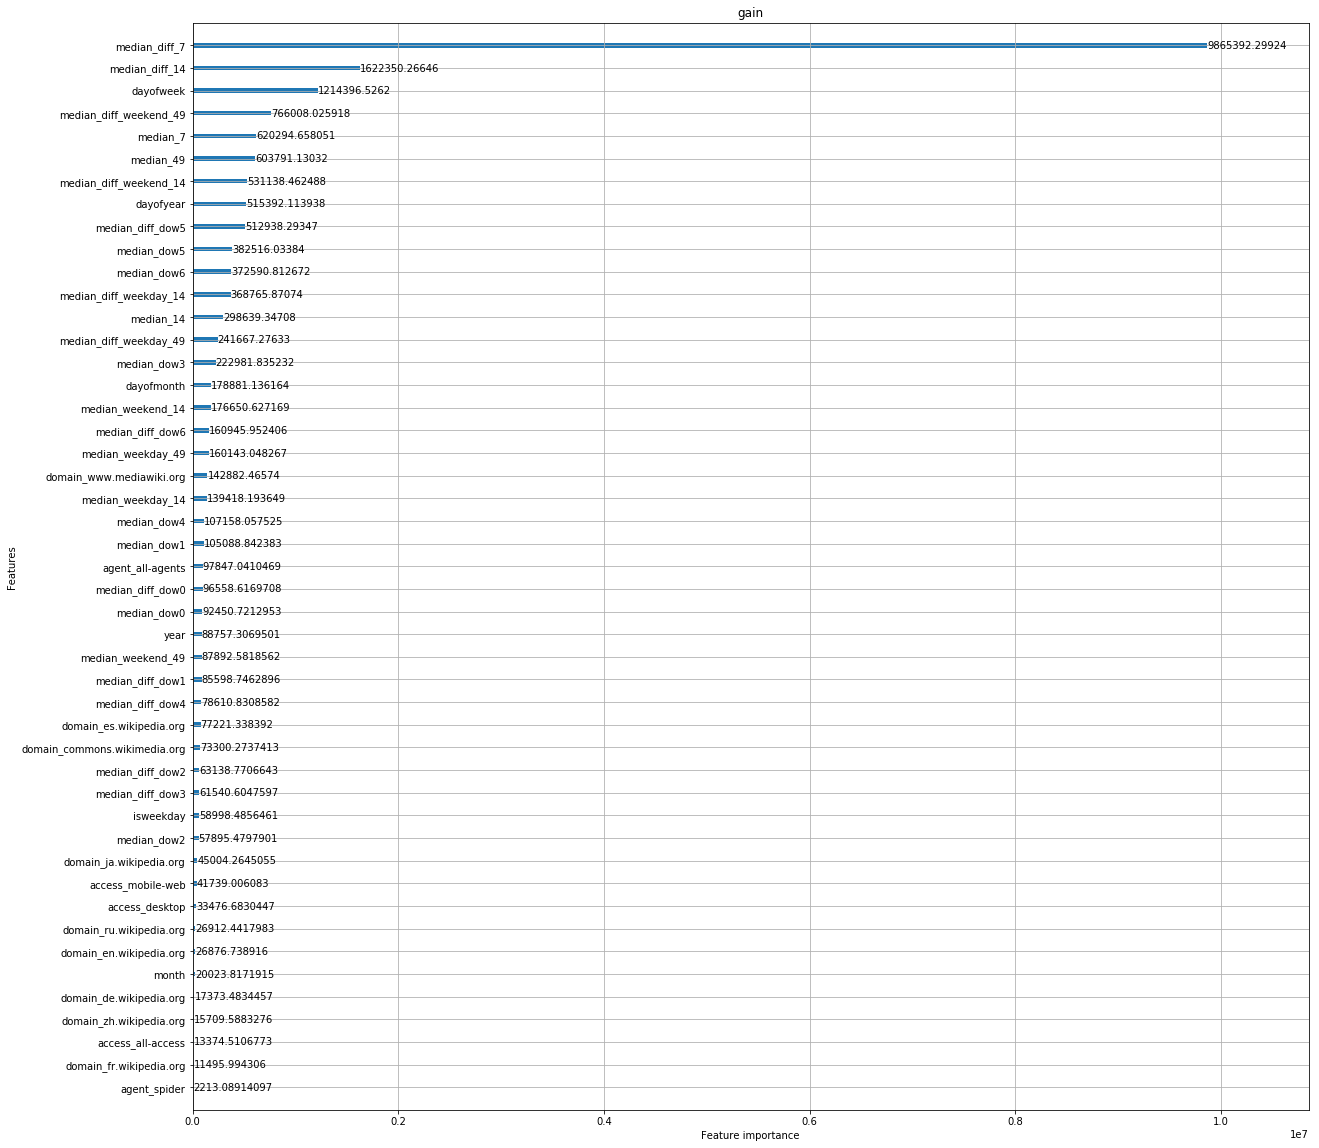

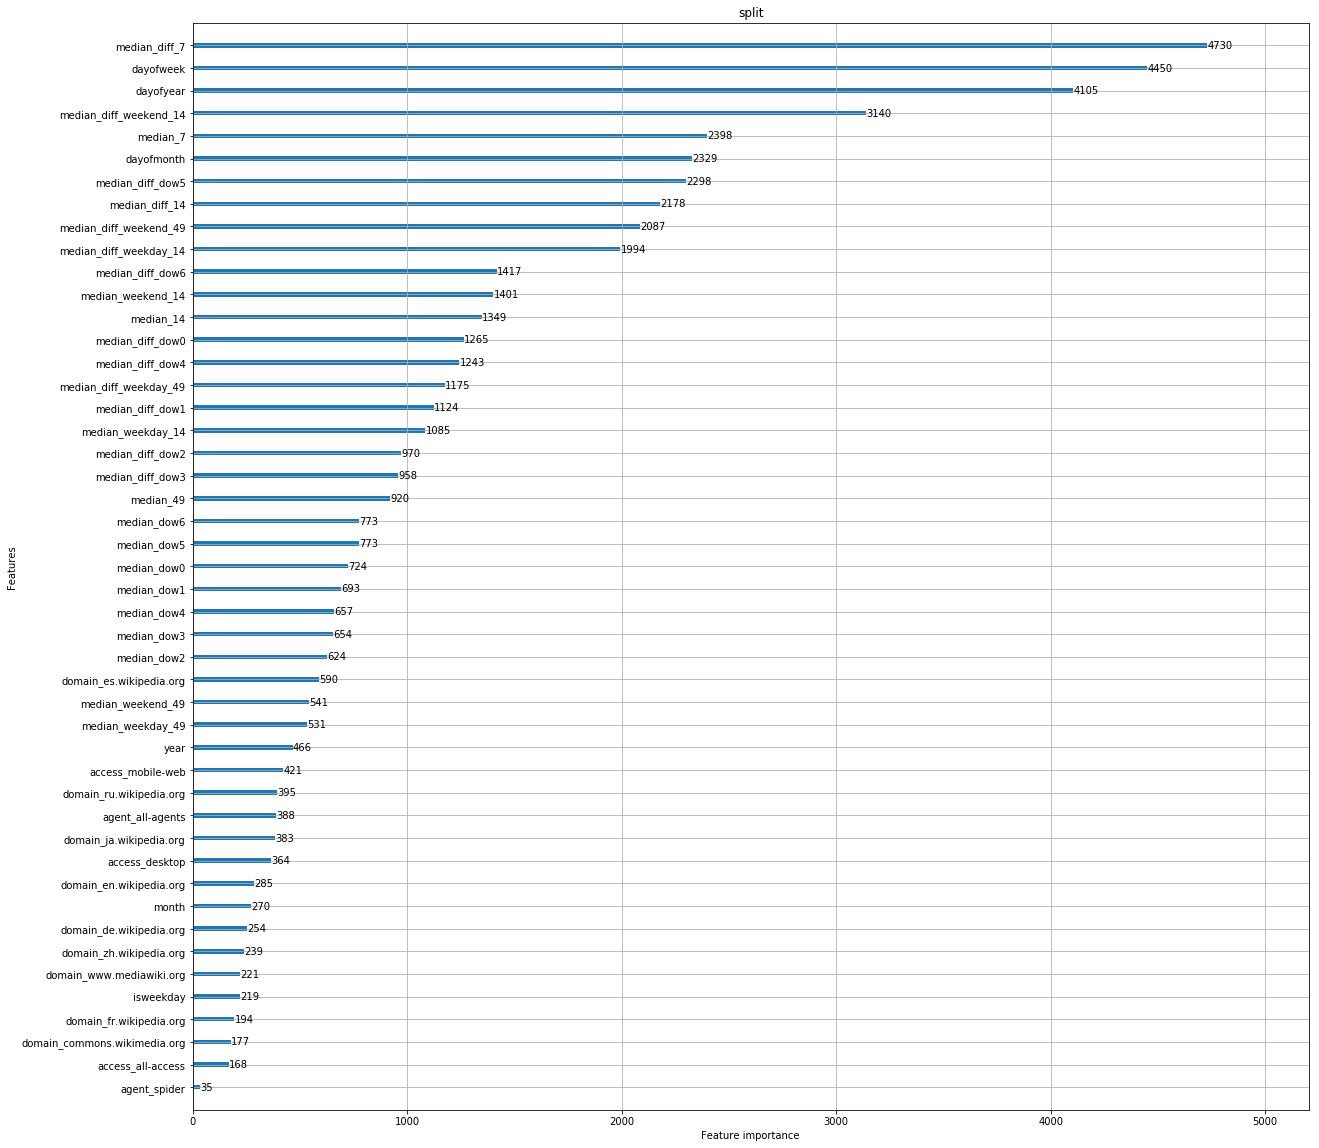

val SMAPE:  39.6129966157
Done training, time cost is 165.1214017868042 seconds


In [27]:
results = []
val_abt = val.drop(['value', 'isval', 'Page', 'date'], axis=1)
val_pred_list = []
print('Done building features, time cost is {} seconds'.format(time.time()-start_time))

for i in range(num_searches):
    params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression_l1',
        'metric': {'l1'},
        'num_leaves': 512,
    #     'min_sum_hessian_in_leaf': 20,
        'max_depth': 12,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.85,
        'bagging_freq': 3,
        'verbose': 1,
        'feature_fraction_seed':np.random.randint(0, 1000),
        'bagging_seed':np.random.randint(0, 1000),
        'data_random_seed':np.random.randint(0, 1000),
    #     'device' : 'gpu'
    }
    name = 'gb_v2_r{}'.format(i)
    start_time = time.time()
    print('Start LightGBM training...')
    # train
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=boosting_rounds,
#                     feval=SMAPE,
                    valid_sets=[lgb_train, lgb_val],
#                   categorical_feature=[],
                    early_stopping_rounds=stopping_rounds)

    print('Save model...')
    # save model to file
    gbm.save_model('model.{}.txt'.format(name))

    print('Plot feature importances...') 
    ax = lgb.plot_importance(gbm, max_num_features=100, importance_type='gain', title = 'gain', figsize=(20, 20))
    plt.show()
    ax = lgb.plot_importance(gbm, max_num_features=100, importance_type='split', title = 'split', figsize=(20, 20))
    plt.show()
    
    val_pred = gbm.predict(val_abt, num_iteration=gbm.best_iteration)
    val_pred_list.append(val_pred)
    print(
        'val SMAPE: ', 
        SMAPE_2(
            val_pred + val['median_{}'.format(base)].values, 
            val.value.values + val['median_{}'.format(base)].values,
        )
    )
    print('Done training, time cost is {} seconds'.format(time.time()-start_time))


In [ ]:
val_pred = np.mean(
    np.concatenate(
        [np.expand_dims(val_pred, 1) for val_pred in val_pred_list], 
        axis=1
    ), 
    axis=1
)
print(
    'ensembled val SMAPE: ', 
    SMAPE_2(
        val_pred + val['median_{}'.format(base)].values, 
        val.value.values + val['median_{}'.format(base)].values,
    )
)

- https://www.kaggle.com/c/web-traffic-time-series-forecasting/discussion/36780
- https://www.kaggle.com/c/web-traffic-time-series-forecasting/discussion/38274#215155

# Prediction

In [ ]:
# name = 'gb4-r0'
# gbm = lgb.Booster(model_file='model.{}.txt'.format(name))

In [34]:
start_time = time.time()
test = pd.read_pickle(root + 'key_2_modified.pkl')

test_date_df = pd.read_pickle(root + 'test_date_df.pkl')
page_df = pd.read_pickle(root + 'page_ohe.pkl')

In [35]:
median_data = []
median_name = [
    '49', 'weekday_49', 'weekend_49', 
    'dow0', 'dow1', 'dow2', 'dow3', 'dow4', 'dow5', 'dow6', 
    '14', 'weekday_14', 'weekend_14',
    '7',
]
for mname in median_name:
    median_data.append(pd.read_pickle(
        '/mnt/WD Black/Dropbox/JuanCode/Insight/Project/data2/' + 'median_{}.pkl'.format(mname)
    ))
    
for i in range(len(median_data)):
    page_df['median_{}'.format(median_name[i])] = np.log1p(median_data[i].iloc[:, -1])
for i in range(len(median_data)):
    if i != 0:
        page_df['median_diff_{}'.format(median_name[i])] = page_df['median_{}'.format(median_name[i])] - page_df['median_{}'.format(base)]

In [36]:
page_df.head()

,Page,domain_commons.wikimedia.org,domain_de.wikipedia.org,domain_en.wikipedia.org,domain_es.wikipedia.org,domain_fr.wikipedia.org,domain_ja.wikipedia.org,domain_ru.wikipedia.org,domain_www.mediawiki.org,domain_zh.wikipedia.org,access_all-access,access_desktop,access_mobile-web,agent_all-agents,agent_spider,median_49,median_weekday_49,median_weekend_49,median_dow0,median_dow1,median_dow2,median_dow3,median_dow4,median_dow5,median_dow6,median_14,median_weekday_14,median_weekend_14,median_7,median_diff_weekday_49,median_diff_weekend_49,median_diff_dow0,median_diff_dow1,median_diff_dow2,median_diff_dow3,median_diff_dow4,median_diff_dow5,median_diff_dow6,median_diff_14,median_diff_weekday_14,median_diff_weekend_14,median_diff_7
0,2NE1_zh.wikipedia.org_all-access_spider,0,0,0,0,0,0,0,0,1,1,0,0,0,1,3.135494,3.135494,3.135494,2.944439,3.295837,3.332205,3.218876,3.135494,3.135494,3.367296,3.295837,3.178054,3.526361,3.332205,0.000000,0.000000,-0.191055,0.160343,0.196710,0.083382,0.000000,0.000000,0.231802,0.160343,0.042560,0.390866,0.196710
1,2PM_zh.wikipedia.org_all-access_spider,0,0,0,0,0,0,0,0,1,1,0,0,0,1,3.044522,3.044522,2.995732,3.044522,2.944439,3.258097,3.044522,3.178054,3.091042,2.564949,3.295837,3.295837,2.639057,3.178054,0.000000,-0.048790,0.000000,-0.100083,0.213574,0.000000,0.133531,0.046520,-0.479573,0.251314,0.251314,-0.405465,0.133531
2,3C_zh.wikipedia.org_all-access_spider,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1.791759,1.609438,1.791759,1.609438,1.609438,2.079442,1.386294,1.945910,1.791759,1.791759,2.079442,1.945910,2.079442,1.609438,-0.182322,0.000000,-0.182322,-0.182322,0.287682,-0.405465,0.154151,0.000000,0.000000,0.287682,0.154151,0.287682,-0.182322
3,4minute_zh.wikipedia.org_all-access_spider,0,0,0,0,0,0,0,0,1,1,0,0,0,1,2.772589,2.772589,2.708050,2.639057,2.708050,2.890372,2.772589,2.890372,2.995732,2.639057,2.995732,2.833213,2.995732,2.995732,0.000000,-0.064539,-0.133531,-0.064539,0.117783,0.000000,0.117783,0.223144,-0.133531,0.223144,0.060625,0.223144,0.223144
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_spider,0,0,0,0,0,0,0,0,1,1,0,0,0,1,2.995732,3.044522,2.995732,3.135494,2.708050,3.044522,3.218876,2.833213,3.044522,2.995732,2.995732,3.044522,2.833213,2.995732,0.048790,0.000000,0.139762,-0.287682,0.048790,0.223144,-0.162519,0.048790,0.000000,0.000000,0.048790,-0.162519,0.000000


In [37]:
test = test.merge(page_df, how='left', on='Page')
test = test.merge(test_date_df, how='left', on='date')

for c, dtype in zip(test.columns, test.dtypes):
    if dtype == np.float64:
        test[c] = test[c].astype(np.float32)
    if dtype == np.int64:
        test[c] = test[c].astype(np.int32)

In [38]:
test.isnull().sum().T

Page                            0
Id                              0
date                            0
domain_commons.wikimedia.org    0
domain_de.wikipedia.org         0
domain_en.wikipedia.org         0
domain_es.wikipedia.org         0
domain_fr.wikipedia.org         0
domain_ja.wikipedia.org         0
domain_ru.wikipedia.org         0
domain_www.mediawiki.org        0
domain_zh.wikipedia.org         0
access_all-access               0
access_desktop                  0
access_mobile-web               0
agent_all-agents                0
agent_spider                    0
median_49                       0
median_weekday_49               0
median_weekend_49               0
median_dow0                     0
median_dow1                     0
median_dow2                     0
median_dow3                     0
median_dow4                     0
median_dow5                     0
median_dow6                     0
median_14                       0
median_weekday_14               0
median_weekend

In [39]:
test.sort_index(axis=1, inplace=True)
test_df = test.drop(['Page', 'date', 'Id'], axis=1)
print('Build features cost {} seconds'.format(time.time()-start_time))

Build features cost 39.02179956436157 seconds


In [40]:
start_time = time.time()
pred_list = []
for i in range(num_searches):
#     name = 'gb12-r{}'.format(i)
#     gbm = lgb.Booster(model_file='model.{}.txt'.format(name))
    pred = gbm.predict(test_df, num_iteration=gbm.best_iteration)
    pred_list.append(pred)

pred = np.mean(
    np.concatenate(
        [np.expand_dims(pred, 1) for pred in pred_list], 
        axis=1
    ), 
    axis=1
)

In [41]:
visit = np.round(np.expm1(pred + test_df['median_{}'.format(base)].values))
pred_df = pd.DataFrame({'Id':test.Id,'Visits':visit})

In [42]:
name = 'gb_v2_r1'
pred_df.to_csv(
    os.path.join(root, 'test_prediction.{}.csv'.format(name)), index=False)
print('Inference takes {} sec'.format(time.time()-start_time))

Inference takes 36.84998655319214 sec


In [44]:
pred_df.head()

,Id,Visits
0,0b293039387a,449.0
1,7114389dd824,450.0
2,057b02ff1f09,454.0
3,bd2aca21caa3,524.0
4,c0effb42cdd5,559.0
